In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip -q "/content/gdrive/MyDrive/Final_dataset.zip"

In [1]:
!pip install tensorflow_addons
!pip install keras-tuner

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import os 
from distutils.dir_util import copy_tree, remove_tree
from PIL import Image
from random import randint
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
WORK_DIR = '/content/Final_dataset/'

CLASSES = ['AD', 'CN', 'MCI']

IMAGE_SIZE = [256, 170]
DIM = (256, 170)

In [4]:
#Performing Image Augmentation to have more data samples

DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, data_format=DATA_FORMAT)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=9000, shuffle=False)

Found 8379 images belonging to 3 classes.


In [5]:
#Retrieving the data from the ImageDataGenerator iterator

train_data, train_labels = train_data_gen.next()


In [6]:
#Getting to know the dimensions of our dataset

print(train_data.shape, train_labels.shape)

(8379, 256, 170, 3) (8379, 3)


In [7]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
print(train_labels.shape, test_labels.shape, val_labels.shape)

(5362, 3) (1676, 3) (1341, 3)


In [8]:
def conv_block(filters, act='relu'):
    """Defining a Convolutional NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

In [9]:
def dense_block(units, dropout_rate, act='relu'):
    """Defining a Dense NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    #block.add(Dropout(dropout_rate))
    
    return block

In [10]:
def construct_model(act='relu'):
    """Constructing a Sequential CNN architecture for performing the classification task. """
    
    model = Sequential([
        Input(shape=(256, 170, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.3),
        #conv_block(256),
        #Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.7),
        dense_block(64, 0.7),
        Dense(3, activation='softmax')        
    ], name = "cnn_model")

    return model

In [11]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#EarlyStopping callback to make sure model is always learning
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [12]:
#Defining other parameters for our CNN model

model = construct_model()

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           #tf.keras.metrics.AUC(name='auc'), 
           tfa.metrics.F1Score(num_classes=3)]

CALLBACKS = [my_callback]
    
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 170, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 170, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 85, 16)       0         
_________________________________________________________________
sequential (Sequential)      (None, 64, 42, 32)        14016     
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 21, 64)        55680     
_________________________________________________________________
sequential_2 (Sequential)    (None, 16, 10, 128)       221952    
_________________________________________________________________
dropout (Dropout)            (None, 16, 10, 128)       0 

In [13]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 80

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS, batch_size=64)

Epoch 1/80
84/84 [==============================] - 35s 331ms/step - loss: 1.1851 - acc: 0.4654 - f1_score: 0.4643 - val_loss: 1.6297 - val_acc: 0.3296 - val_f1_score: 0.1653
Epoch 2/80
84/84 [==============================] - 23s 273ms/step - loss: 0.8142 - acc: 0.6212 - f1_score: 0.6215 - val_loss: 2.3579 - val_acc: 0.3296 - val_f1_score: 0.1653
Epoch 3/80
84/84 [==============================] - 23s 275ms/step - loss: 0.6328 - acc: 0.7423 - f1_score: 0.7421 - val_loss: 3.4076 - val_acc: 0.3430 - val_f1_score: 0.1703
Epoch 4/80
84/84 [==============================] - 23s 275ms/step - loss: 0.5231 - acc: 0.7857 - f1_score: 0.7860 - val_loss: 4.0571 - val_acc: 0.3900 - val_f1_score: 0.2625
Epoch 5/80
84/84 [==============================] - 23s 275ms/step - loss: 0.3820 - acc: 0.8518 - f1_score: 0.8520 - val_loss: 4.2503 - val_acc: 0.3445 - val_f1_score: 0.1738
Epoch 6/80
84/84 [==============================] - 23s 276ms/step - loss: 0.2617 - acc: 0.9056 - f1_score: 0.9054 - val_loss

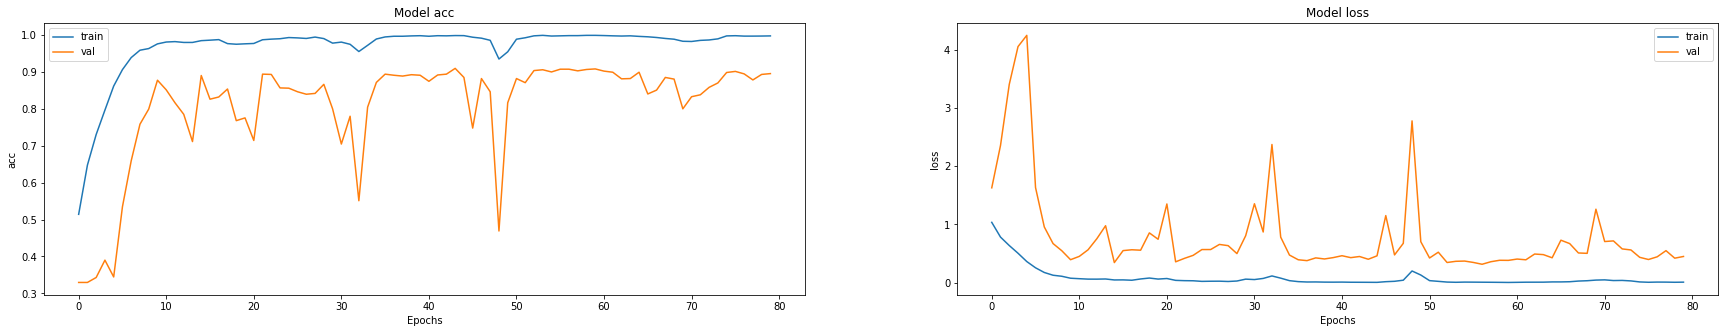

In [14]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 2, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [15]:
#Evaluating the model on the data

#train_scores = model.evaluate(train_data, train_labels)
val_scores = model.evaluate(val_data, val_labels)
test_scores = model.evaluate(test_data, test_labels)

#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

53/53 [==============================] - 3s 61ms/step - loss: 0.5236 - acc: 0.9021 - f1_score: 0.9016
Validation Accuracy: 89.56%
Testing Accuracy: 90.21%


In [16]:
pred_labels = model.predict(test_data)

In [17]:
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

              precision    recall  f1-score   support

          AD       0.91      0.95      0.93       573
          CN       0.92      0.87      0.89       540
         MCI       0.88      0.88      0.88       563

   micro avg       0.90      0.90      0.90      1676
   macro avg       0.90      0.90      0.90      1676
weighted avg       0.90      0.90      0.90      1676
 samples avg       0.90      0.90      0.90      1676



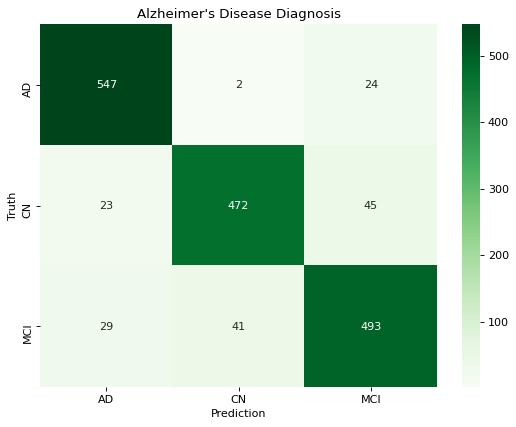

In [18]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [19]:
print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 90.15 %
Matthew's Correlation Coefficient: 85.34 %
